# Модуль 10. **Згорткові нейронні мережі** 
## Частина 2

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tensorflow as tf

import keras

from keras import layers, models
from keras import optimizers
from keras import losses
from keras import metrics

from keras.datasets import fashion_mnist

from keras.applications import VGG16
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from PIL import Image
import copy

In [78]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
CYAN = "\033[36m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання
**Частина 2**

В цій частині ми знову будемо працювати з датасетом _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, **що використовує VGG16 в якості згорткової основи**.


Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. **Під час навчання використовуйте прийоми донавчання та виділення ознак**.



Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

     Завантаження та аналіз даних 

In [79]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [80]:
class_names = [
    "T-shirt/top",  # "Футболка/майка",
    "Trouser",  # "Штани",
    "Pullover",  # "Світшот",
    "Dress",  # "Сукня",
    "Coat",  # "Пальто",
    "Sandal",  # "Сандалі",
    "Shirt",  # "Сорочка",
    "Sneaker",  # "Кросівки",
    "Bag",  # "Сумка",
    "Ankle boot",  # "Ботильйони",
]

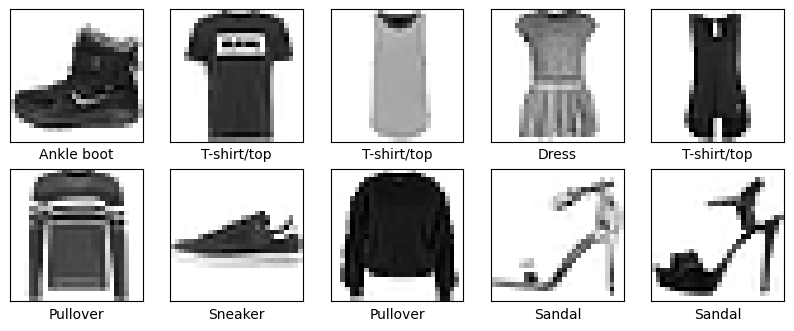

In [81]:
num_to_plot = 10

plt.figure(figsize=(10, 10))

for i in range(num_to_plot):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

In [82]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [83]:
def resize_images(images):
    resized_images = []
    for img in images:
        # змінити розмір зображення до 32х32 Image.BILINEAR
        img_resized = np.array(Image.fromarray(img).resize((32, 32), Image.BILINEAR))
        # перетворити grayscale в RGB format
        img_rgb = np.repeat(img_resized[:, :, np.newaxis], 3, axis=2)
        resized_images.append(img_rgb)
    return np.array(resized_images)

In [84]:
train_images = resize_images(train_images)
test_images = resize_images(test_images)

In [85]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 32, 32, 3)
(60000,)
(10000, 32, 32, 3)
(10000,)


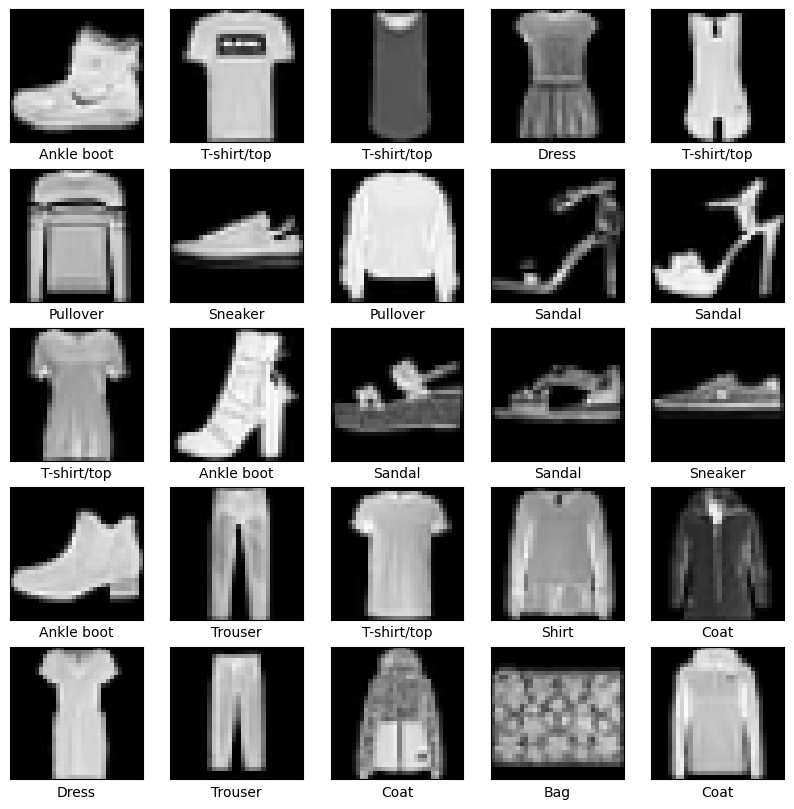

In [86]:
num_to_plot = 25

plt.figure(figsize=(10, 10))

for i in range(num_to_plot):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show() 

### Допоміжні функції

     Функція друку поточних параметрів 
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [87]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

     Функція відображення графіків історії точності та втрат 
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [88]:
def plt_history(history):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    plt.ylim(0, 1)
    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція формування optimizer'а 

In [89]:
def make_optimizer(
    optimizer_str: str, initial_learning_rate, decay_steps, decay_rate=0.9
):

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
    )

    if optimizer_str == "adam":
        optimizer = optimizers.Adam(learning_rate=lr_schedule)
    elif optimizer_str == "sgd":
        optimizer = optimizers.SGD(learning_rate=lr_schedule)
    elif optimizer_str == "rmsprop":
        optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.AdamW(learning_rate=lr_schedule)

    return optimizer

     Функція формування callback 
######      Аргументи: <br>1.  callbacks - Список callback'ів<br>2. patience - Кількість епох без покращення, після яких швидкість навчання буде знижена<br>3. factor_lr - Коефіцієнт, на який швидкість навчання буде знижена _(new_lr = lr * factor)_

In [90]:
def make_callback(callbacks, patience=5, factor_lr=0.4, min_lr=1e-8):

    callback = []

    if "ReduceLROnPlateau" in callbacks:
        callback.append(
            ReduceLROnPlateau(
                monitor="val_loss", factor=factor_lr, patience=patience, min_lr=min_lr
            )
        )

    if "EarlyStopping" in callbacks:
        callback.append(
            EarlyStopping(
                monitor="val_accuracy", patience=patience, restore_best_weights=True
            )
        )

    return callback

     Параметри для тренування моделі 1 

In [92]:
# Оптимальні параметри модель 1.
optimal_parameters = {
    "epochs": 30,  # 30,
    "batch_size": 32,  # 128, #64,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": 'rmsprop', #  "adam", 
    # "initial_lr": 0.01,
    # "decay_steps": 10000,
    # "decay_rate": 0.9,
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
    # "callbacks": [""],
    # "factor_lr": 0.2,
    # "patience": 5,
    # "min_lr": 1e-8,
}
# параметри для створення та тренування моделі
epochs = optimal_parameters["epochs"]
batch_size = optimal_parameters["batch_size"]
dropout_rate = optimal_parameters["dropout_rate"]
loss_function = optimal_parameters["loss_function"]
optimizer = optimal_parameters["optimizer"]
# initial_lr = optimal_parameters["initial_lr"]
# decay_steps = optimal_parameters["decay_steps"]
# decay_rate = optimal_parameters["decay_rate"]
hidden_units = optimal_parameters["hidden_units"]
activation = optimal_parameters["activation"]
metrics = optimal_parameters["metrics"]
# callbacks = optimal_parameters["callbacks"]
# factor_lr = optimal_parameters["factor_lr"]
# patience = optimal_parameters["patience"]
# min_lr = optimal_parameters["min_lr"]

In [93]:
# параметри керування виводом інформації під час тренування
verbose = 1
summary = 1

***
### **Модель для тренування 1** 
***

```
model_vgg16 = models.Sequential(
    [
        base_model_vgg16,
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax"),
    ]
)

model_vgg16.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=32,
    validation_data=(test_images, test_labels),
)
```

In [94]:
# VGG16 model

base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Freezing of the convolutional base
base_model_vgg16.trainable = False

# # Build model with VGG16
# model_vgg16 = models.Sequential(
#     [
#         base_model_vgg16,
#         layers.Flatten(),
#         layers.Dense(hidden_units, activation=activation),
#         layers.Dropout(dropout_rate),
#         layers.Dense(hidden_units // 2, activation=activation),
#         layers.Dropout(dropout_rate),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

# Adding fully connected layers for classification
x = layers.Flatten()(base_model_vgg16.output)
x = layers.Dense(hidden_units, activation=activation)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(hidden_units // 2, activation=activation)(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(10, activation="softmax")(x)

model_vgg16 = models.Model(inputs=base_model_vgg16.input, outputs=output)

# Compilation
# model_vgg16.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# model_vgg16.compile(
#     optimizer=make_optimizer(optimizer, initial_lr, decay_steps, decay_rate),
#     loss=loss_function,
#     metrics=metrics,
# )

model_vgg16.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics,
)

if summary:
    model_vgg16.summary()

In [96]:
# Model training
history = model_vgg16.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    # callbacks=make_callback(callbacks, patience, factor_lr, min_lr),
    verbose=verbose,
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 150s 159ms/step - accuracy: 0.7225 - loss: 0.7885 - val_accuracy: 0.7977 - val_loss: 0.5754
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 158s 168ms/step - accuracy: 0.8039 - loss: 0.5577 - val_accuracy: 0.8140 - val_loss: 0.5280
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 162s 173ms/step - accuracy: 0.8159 - loss: 0.5254 - val_accuracy: 0.8349 - val_loss: 0.4666
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 173s 184ms/step - accuracy: 0.8227 - loss: 0.5048 - val_accuracy: 0.8270 - val_loss: 0.4751
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 159s 169ms/step - accuracy: 0.8221 - loss: 0.5162 - val_accuracy: 0.8348 - val_loss: 0.4585
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 180s 192ms/step - accuracy: 0.8309 - loss: 0.4927 - val_accuracy: 0.8451 - val_loss: 0.4476
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 175s 187ms/step - accuracy: 0.8316 - loss: 0.4756 - val_accuracy: 0.8379 - val_loss: 0.4522
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 179s 191ms/step - accuracy: 0.8328 -

Поточні параметри:
 epochs 	= 30
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 initial_lr 	= 0.01
 decay_steps 	= 10000
 decay_rate 	= 0.9
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5
 min_lr 	= 1e-08


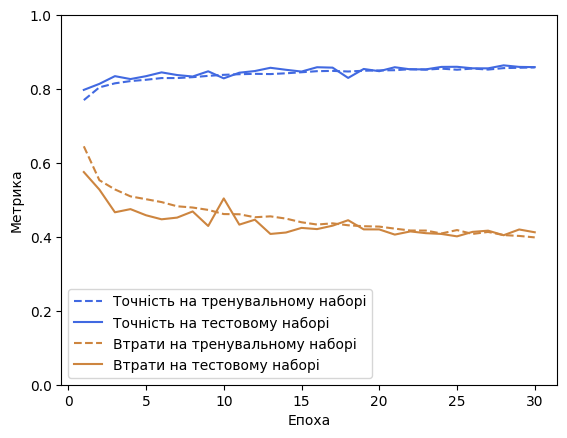

          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 189s 101ms/step - accuracy: 0.8822 - loss: 0.3194
          тренувальні дані:   0.880383312702179 
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8636 - loss: 0.4002
          тестові дані:       0.8593000173568726 


In [97]:
# оптимальні параметри
print_parameters(optimal_parameters)

# побудова графіку
plt_history(history)

# дані про точність моделі
print("          Точність:")
train_loss, train_acc = model_vgg16.evaluate(train_images, train_labels)
print("          тренувальні дані: ", YELLOW, train_acc, RESET)

test_loss, test_acc = model_vgg16.evaluate(test_images, test_labels)
print("          тестові дані:     ", YELLOW, test_acc, RESET)

<div class="alert alert-block alert-info">
<b>Висновки model_VGG16_1:</b> 
<p>Точність моделі склала <b>85.93%</b>, що недостатньо<br>Спробуємо застосувати розморожування шарів згорткової основи для донавчання </p>
</div>

In [98]:
model_vgg16.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         2,57

 Total params: 15,904,351 (60.67 MB)

 Trainable params: 396,554 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 793,109 (3.03 MB)

***
### **Модель для тренування 2** 
***
_Зробимо донавчання останніх трьох шарів: **block5_conv1, block5_conv2** та **block5_conv3**_. <br> 
_Решту шарів залишимо без змін_

```
model_vgg16_2 = models.Sequential(
    [
        base_model_vgg16,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(10, activation="softmax"),
    ]
)

model_vgg16_2.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16_2.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=64,
    validation_data=(test_images, test_labels),
)
```

In [ ]:
# Оптимальні параметри модель 2.
optimal_parameters = {
    "epochs": 30,  # 30,
    "batch_size": 64,  # 128, #64,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",  # 'rmsprop',
    # "initial_lr": 0.01,
    # "decay_steps": 10000,
    # "decay_rate": 0.9,
    "hidden_units": 512,
    "activation": "relu",
    "metrics": ["accuracy"],
    # "callbacks": [""],
    # "factor_lr": 0.2,
    # "patience": 5,
    # "min_lr": 1e-8,
}
# параметри для створення та тренування моделі
epochs = optimal_parameters["epochs"]
batch_size = optimal_parameters["batch_size"]
dropout_rate = optimal_parameters["dropout_rate"]
loss_function = optimal_parameters["loss_function"]
optimizer = optimal_parameters["optimizer"]
# initial_lr = optimal_parameters["initial_lr"]
# decay_steps = optimal_parameters["decay_steps"]
# decay_rate = optimal_parameters["decay_rate"]
hidden_units = optimal_parameters["hidden_units"]
activation = optimal_parameters["activation"]
metrics = optimal_parameters["metrics"]
# callbacks = optimal_parameters["callbacks"]
# factor_lr = optimal_parameters["factor_lr"]
# patience = optimal_parameters["patience"]
# min_lr = optimal_parameters["min_lr"]

In [99]:
# VGG16 model 2
base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Freezing of the convolutional base
# base_model_vgg16.trainable = False

base_model_vgg16.trainable = True
set_trainable = False
for layer in model_vgg16.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# # Build model with VGG16
# model_vgg16_2 = models.Sequential(
#     [
#         base_model_vgg16,
#         layers.Flatten(),
#         layers.Dense(hidden_units, activation=activation),
#         layers.Dropout(dropout_rate),
#         layers.Dense(hidden_units // 2, activation=activation),
#         layers.Dropout(dropout_rate),
#         layers.Dense(10, activation="softmax"),
#     ]
# )

x = layers.Flatten()(base_model_vgg16.output)
x = layers.Dense(hidden_units, activation=activation)(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(hidden_units // 2, activation=activation)(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(10, activation="softmax")(x)
model_vgg16_2 = models.Model(inputs=base_model_vgg16.input, outputs=output)

# Compilation
# model_vgg16.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

# model_vgg16_2.compile(
#     optimizer=make_optimizer(optimizer, initial_lr, decay_steps, decay_rate),
#     loss=loss_function,
#     metrics=metrics,
# )

model_vgg16_2.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss=loss_function,
    metrics=metrics,
)

In [100]:
# Model training
history = model_vgg16_2.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    # callbacks=make_callback(callbacks, patience, factor_lr, min_lr),
    verbose=verbose,
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 650s 691ms/step - accuracy: 0.7271 - loss: 0.7897 - val_accuracy: 0.8389 - val_loss: 0.4351
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 624s 665ms/step - accuracy: 0.8795 - loss: 0.3432 - val_accuracy: 0.8944 - val_loss: 0.2969
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 634s 676ms/step - accuracy: 0.9026 - loss: 0.2829 - val_accuracy: 0.9017 - val_loss: 0.2733
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 649s 692ms/step - accuracy: 0.9105 - loss: 0.2514 - val_accuracy: 0.9104 - val_loss: 0.2538
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 639s 681ms/step - accuracy: 0.9184 - loss: 0.2272 - val_accuracy: 0.8960 - val_loss: 0.2677
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 645s 688ms/step - accuracy: 0.9255 - loss: 0.2102 - val_accuracy: 0.9201 - val_loss: 0.2280
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 642s 684ms/step - accuracy: 0.9355 - loss: 0.1862 - val_accuracy: 0.9083 - val_loss: 0.2711
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 2087s 2s/step - accuracy: 0.9359 - l

Поточні параметри:
 epochs 	= 30
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 initial_lr 	= 0.01
 decay_steps 	= 10000
 decay_rate 	= 0.9
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5
 min_lr 	= 1e-08


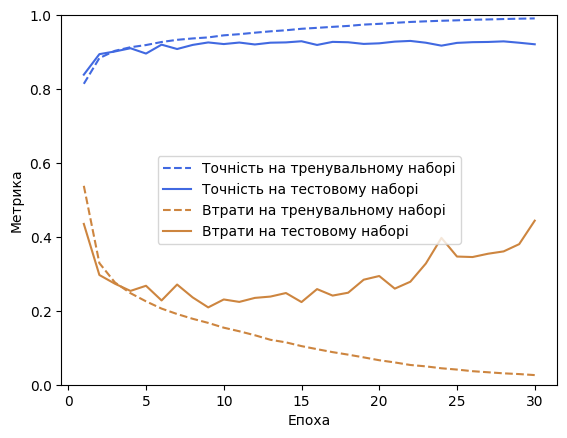

          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 194s 103ms/step - accuracy: 0.9863 - loss: 0.0394
          тренувальні дані:   0.9851833581924438 
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.9189 - loss: 0.4412
          тестові дані:       0.9211000204086304 


In [101]:
# оптимальні параметри
print_parameters(optimal_parameters)

# побудова графіку
plt_history(history)

# дані про точність моделі
print("          Точність:")
train_loss, train_acc = model_vgg16_2.evaluate(train_images, train_labels)
print("          тренувальні дані: ", YELLOW, train_acc, RESET)

test_loss, test_acc = model_vgg16_2.evaluate(test_images, test_labels)
print("          тестові дані:     ", YELLOW, test_acc, RESET)

<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>За результатами роботи можемо стверджувати, що використання моделі VGG16 дозволяє отримувати досить високі результати, особливо при застосуванні розмороження та перенавчання кількох (трьох) верхніх шарів<br>Максимальна точність на тестових даних для простої моделі з використанням VGG16 сягнула <b>85.93%</b><br>Застосування розморожуванням та донавчання дозволило підняти точність до <b>92.11%</b><br><i>Зазначу значне підвищення часу навчання моделі з використання VGG16, в порівнянні з простою згортковою моделлю (завдання 1)<br>Таке зростання часу навчання моделі значно ускладнює проведення експериментів з параметрами моделі</i></p>
</div>